This code was adapted from Dudas et al, 2016

In [17]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
import matplotlib.patheffects as path_effects
from IPython.display import HTML
import datetime as dt
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
import csv
import math,re,os,json
import numpy as np
import pandas as pd
from matplotlib.ticker import FormatStrFormatter
from scipy.stats import gaussian_kde
from scipy.stats import spearmanr
from scipy.stats import linregress
import bezier as bz
import colorsys
import baltic as bt
import json
import numpy as np
from matplotlib.patches import Polygon

typeface='Helvetica Neue'

mpl.rcParams['font.weight']=300
mpl.rcParams['axes.labelweight']=300
mpl.rcParams['font.family']=typeface
mpl.rcParams['font.size']=22

In [18]:
def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])

def metricDistance(pointA,pointB):
    """ Calculate distance in kilometers along planet's surface from longitude and latitude. """
    R=6371 ## kilometers
    lon1,lat1=pointA
    lon2,lat2=pointB
    
    phi1=math.radians(lat1)
    phi2=math.radians(lat2)
    
    deltaPhi=math.radians(lat2-lat1)
    deltaLam=math.radians(lon2-lon1)
    
    a=math.sin(deltaPhi/2.0) * math.sin(deltaPhi/2.0) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLam/2.0) * math.sin(deltaLam/2.0)
    c = 2.0 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    
    return R*c

def Bezier_control(pointA,pointB,height,frac):
    """ 
    Given a line defined by 2 points A & B, 
    find a third point at a given distance (height) that defines a line perpendicular to line AB which intercepts AB at fraction (frac) along AB.
    Equation derived by Luiz Max Fagundes de Carvalho (University of Edinburgh).
    """
    x1,y1=pointA
    x2,y2=pointB

    sign=1
    if x1>x2:
        sign=-1

    slope = (y2-y1) / (x2-x1)
    d=np.sqrt((y2-y1)**2 + (x2-x1)**2) ## distance between points
    
    h=np.sqrt(height**2+(d*frac)**2) ## distance between desired height and point along line

    n1=x1+h*np.cos(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign ## magic
    n2=y1+h*np.sin(np.arctan(height/float(d)/frac)+np.arctan(slope))*sign

    return (n1,n2) ## return third point's coordinate
def kde_scipy(vals1, vals2, interval1, interval2, N):
    """Performs 2D kernel density estimation.
    vals1, vals2 are the values of two variables (columns)
    interval1: (a, b) interval for vals1 over which to estimate first axis KDE
    interval2: (c, d) interval for vals2 over which to estimate second axis KDE
    N: number of equally spaced points over which to estimate KDE.
    """
    a, b = interval1
    c, d = interval2
    x = np.linspace(a, b, N)
    y = np.linspace(c, d, N)
    X, Y = np.meshgrid(x, y)
    positions = np.vstack([X.ravel(), Y.ravel()])

    values = np.vstack([vals1, vals2])
    kernel = gaussian_kde(values)
    Z = np.reshape(kernel(positions).T, X.shape)
    return [x, y, Z]

def decimalDate(date, fmt="%Y-%m-%d"):
    components = date.split('-')
    if len(components) == 1:
        components = components + ['01', '01']  # Add dummy month and day
    elif len(components) == 2:
        components = components + ['01']  # Add dummy day

    formatted_date = '-'.join(components)
    adatetime = dt.datetime.strptime(formatted_date, fmt)
    year = adatetime.year
    boy = dt.datetime(year, 1, 1)
    eoy = dt.datetime(year + 1, 1, 1)
    return year + ((adatetime - boy).total_seconds() / ((eoy - boy).total_seconds()))


def convertDate(x, start, end):
    """ Converts calendar dates between given formats """
    return dt.datetime.strftime(dt.datetime.strptime(x, start), end)

In [19]:
def hpd(data, level):
    """
    Return highest posterior density interval from a list,
    given the percent posterior density interval required.
    """
    d = list(data)
    d.sort()

    nData = len(data)
    nIn = int(round(level * nData))
    if nIn < 2 :
        return None
    #raise RuntimeError("Not enough data. N data: %s"%(len(data)))
 
    i = 0
    r = d[i+nIn-1] - d[i]
    for k in range(len(d) - (nIn - 1)) :
        rk = d[k+nIn-1] - d[k]
        if rk < r :
            r = rk
            i = k

    assert 0 <= i <= i+nIn-1 < len(d)
 
    return (d[i], d[i+nIn-1])


#### code taken from Chris Slocum's website:
## http://schubert.atmos.colostate.edu/~cslocum/custom_cmap.html
def make_cmap(colors, position=None, bit=False):
    '''
    make_cmap takes a list of tuples which contain RGB values. The RGB
    values may either be in 8-bit [0 to 255] (in which bit must be set to
    True when called) or arithmetic [0 to 1] (default). make_cmap returns
    a cmap with equally spaced colors.
    Arrange your tuples so that the first color is the lowest value for the
    colorbar and the last is the highest.
    position contains values from 0 to 1 to dictate the location of each color.
    '''
    import matplotlib as mpl
    import numpy as np
    bit_rgb = np.linspace(0,1,256)
    if position == None:
        position = np.linspace(0,1,len(colors))
    else:
        if len(position) != len(colors):
            sys.exit("position length must be the same as colors")
        elif position[0] != 0 or position[-1] != 1:
            sys.exit("position must start with 0 and end with 1")
    if bit:
        for i in range(len(colors)):
            colors[i] = (bit_rgb[colors[i][0]],
                         bit_rgb[colors[i][1]],
                         bit_rgb[colors[i][2]])
    cdict = {'red':[], 'green':[], 'blue':[]}
    for pos, color in zip(position, colors):
        cdict['red'].append((pos, color[0], color[0]))
        cdict['green'].append((pos, color[1], color[1]))
        cdict['blue'].append((pos, color[2], color[2]))

    cmap = mpl.colors.LinearSegmentedColormap('my_colormap',cdict,256)
    return cmap

#### code stolen from seaborn to desaturate colours
def desaturate(color, prop):
    """Decrease the saturation channel of a color by some percent.
    Parameters
    ----------
    color : matplotlib color
        hex, rgb-tuple, or html color name
    prop : float
        saturation channel of color will be multiplied by this value
    Returns
    -------
    new_color : rgb tuple
        desaturated color code in RGB tuple representation
    """
    # Check inputs
    if not 0 <= prop <= 1:
        raise ValueError("prop must be between 0 and 1")

    # Get rgb tuple rep
    rgb = mpl.colors.colorConverter.to_rgb(color)

    # Convert to hls
    h, l, s = colorsys.rgb_to_hls(*rgb)

    # Desaturate the saturation channel
    s *= prop

    # Convert back to rgb
    new_color = colorsys.hls_to_rgb(h, l, s)

    return new_color

In [39]:
xml_path = '../13_GLM_MPOX/13_predictor_DEC_GLM_MPOX_Final.xml'
history_path = '../13_GLM_MPOX/DEC_GLM_MPOX_Final.history.log'
gn_paths = '../13_GLM_MPOX/DEC_GLM_MPOX_Final.location.glm.log'
loc_path = "../December_Mpox/location_only.csv"
filenames='../December_Mpox/gadm41_NGA_2.json'

In [31]:
tip_dates=[]
for line in open(xml_path,'r'): 
    cerberus=re.search('<taxon id="[A-Za-z\|\|0-9?]+\|([0-9\-]+)',line) ## collect all sequence collection dates
    if cerberus is not None:
        tip_dates.append(cerberus.group(1))
mostRecent=max(map(decimalDate,tip_dates)) ## find most recent one
print("Most recent date:", mostRecent)
#print(tip_dates)

Most recent date: 2023.4109589041095


In [32]:

location_to_country={}
locations = []
polygons = {}
location_points = {}

#loc_path = "../December_Mpox/location_only.csv"

#filename = '../Downloads/gadm41_NGA_1-2.json'
#def loadData():
with open(filenames, 'r') as file:
    data = json.load(file)
    features = data['features']
for loc in features:
    poly = loc['geometry']['coordinates']  # Keep it as list
    country = loc['properties']['COUNTRY']
    location = loc['properties']['NAME_1']
    if location not in locations:
        locations.append(location)
    polygons[location] = []
    location_points[location] = []
    location_to_country[location] = country
    
    if loc['geometry']['type'] == 'MultiPolygon':
        for part in poly:
            for coords in part:
                xs, ys = zip(*coords)  # Directly unpack coordinates
                location_points[location].append(np.vstack(list(zip(xs, ys))))
                
    elif loc['geometry']['type'] == 'Polygon':
        for coords in poly:
            xs, ys = zip(*coords)
            location_points[location].append(np.vstack(list(zip(xs, ys))))

    # Creating Polygon objects from location points
    complete_location = []
    for part in location_points[location]:
        complete_location.append(Polygon(part, closed=True))  # Use keyword argument
    
    polygons[location] = complete_location

In [33]:
xs = np.array(coords)[:, 0]
ys = np.array(coords)[:, 1]
stacked_coords = np.vstack(list(zip(xs, ys)))
stacked_coords = stacked_coords.astype(object)
location_points[location].append(stacked_coords)

In [34]:
def metricDistance(pointA,pointB):
    """ Calculate distance in kilometers along planet's surface from longitude and latitude. """
    R=6371 ## kilometers
    lon1,lat1=pointA
    lon2,lat2=pointB
    
    phi1=math.radians(lat1)
    phi2=math.radians(lat2)
    
    deltaPhi=math.radians(lat2-lat1)
    deltaLam=math.radians(lon2-lon1)
    
    a=math.sin(deltaPhi/2.0) * math.sin(deltaPhi/2.0) + math.cos(phi1) * math.cos(phi2) * math.sin(deltaLam/2.0) * math.sin(deltaLam/2.0)
    c = 2.0 * math.atan2(math.sqrt(a),math.sqrt(1-a))
    
    return R*c





popCentres = {}

# Import population centroids
with open(loc_path, 'r') as file:
    reader = csv.DictReader(file)
    # Skip the header row
    #next(reader)
    for row in reader:
        #print(row)
        location = row['location']
        latitude = float(row['Lat'])
        longitude = float(row['Long'])
        popCentres[location] = (latitude, longitude)
#print(popCentres)


distance_matrix={x:{y:0 for y in popCentres.keys()} for x in popCentres.keys()} ## find distance in kilometres between every location population centroid
for x in popCentres.keys():
    pointA=popCentres[x]
    for y in popCentres.keys():
        pointB=popCentres[y]
        distance_matrix[x][y]=metricDistance(pointA,pointB)

all_times=[]
all_distances=[]

jump_matrix={x:{y:0 for y in popCentres.keys() if x!=y} for x in popCentres.keys()}
posteriors=[]
location_jump_matrix={x:{y:{} for y in locations} for x in locations}

jumps_to={y:[] for y in popCentres.keys()}
jumps_from={y:[] for y in popCentres.keys()}

MCMClen=0

burnin = 100000
with open(history_path, 'r') as file:
    row_number = 0
    for line in file:  ## iterate through the history file
        row_number += 1
        if row_number <= 3:
            continue  # Skip the first three rows

        l = line.strip('\n').split('\t')
        if 'state' in line:
            pass
        elif float(l[0]) >= burnin:
            MCMClen += 1
            try:
                N_transitions = int(float(l[-1]))
            except:
                N_transitions = int(float(line.split(' ')[-1].strip('\n')))
            
            cerberus = re.findall('{[0-9]+,[0-9\.]+,[A-Za-z]+,[A-Za-z]+}', l[2]) ## fetch all transitions
            
            local_matrix={x:{y:0 for y in popCentres.keys() if x!=y} for x in popCentres.keys()}

            for trans in cerberus: ## iterate over each event
                log, height, origin, destination = trans[1:-1].split(',')
                
                height=float(height)
                
                 
                pointA=popCentres[origin]
                pointB=popCentres[destination]
                
                distance=distance_matrix[origin][destination]
                absoluteTime=mostRecent-height
                
                all_times.append(absoluteTime) ## remember time of transition

                all_distances.append(distance) ## remember distance

                jump_matrix[origin][destination]+=1 ## add to number of known transitions between locations

                jumps_to[destination].append(absoluteTime) ## add time to known jumps to and from the locations
                jumps_from[origin].append(absoluteTime)
                if origin in location_jump_matrix and destination in location_jump_matrix[origin]:
                    if MCMClen in location_jump_matrix[origin][destination]:
                        location_jump_matrix[origin][destination][MCMClen].append(absoluteTime)
                    else:
                        location_jump_matrix[origin][destination][MCMClen] = [absoluteTime]
                else:
                    location_jump_matrix.setdefault(origin, {}).setdefault(destination, {MCMClen: [absoluteTime]})
              
                if len(cerberus)!=N_transitions: ## make sure that the number of found jumps matches what BEAST reported
                    print ('Number of transitions found (%d) does not match reported number (%d) at state %s'%(len(cerberus),N_transitions,l[0]))

                


print ('Done! (%d MCMC states loaded)'%(MCMClen))

Done! (3945 MCMC states loaded)


In [40]:
import re

predictor_description = {}  # This will contain the predictor description taken from the comment before the GLM matrix
predictors = []  # This will contain the predictor names

read_matrix = False  # Flag to read the matrices
description = ''

read_loc = False  # Flag to read locations
xml_districts = []  # This will contain location names

counter = 1
store = ''
print ('predictors found:')
for line in open(xml_path, 'r'):  # Iterate through XML by line
    descriptionRegex = r'<!-- predictor [0-9]+\: ([A-Za-z\_\.\(\)\-0-9\, +>]+) -->'
    matrixRegex = r'<parameter id="([A-Za-z0-9\_\.]+)" value="'

    matrixID = re.search(matrixRegex, line)  # Search for matrix
    valid_description = re.search(descriptionRegex, store)  # Check if the previous line had a valid description of a predictor
    if matrixID is not None and valid_description is not None:
        predictor = matrixID.group(1)
        predictors.append(predictor)
        predictor_description[predictor] = description
        print (' & %s & %s \\\\ \\hline' % (predictor, description))

        counter += 1

    descriptionID = re.search(descriptionRegex, line)  # Search for matrix description
    if descriptionID is not None:
        description = descriptionID.group(1)

    if 'location.dataType' in line:  # Identify when to start reading location names
        read_loc = True

    cerberus = re.search('<state code="([A-Za-z]+)"/>', line)  # Log location
    if read_loc and cerberus is not None:
        xml_districts.append(cerberus.group(1))

    store = line  # Remember line for next iteration

burnin = 1000  # Define burnin for GLM log file
trait = 'location'

required_coeffs = ['%s.glmCoefficients%d' % (trait, x+1) for x in range(len(predictors))]  # Identify the indicator and coefficient names in the log file
required_indicators = ['%s.coefIndicators%d' % (trait, x+1) for x in range(len(predictors))]

GLM_coeffs = {x: [] for x in predictors}  # Create a dictionary of lists that will contain posterior samples
GLM_indicators = {x: [] for x in predictors}

lpaths = '../13_GLM_MPOX/DEC_GLM_MPOX_Final.location.glm.log',
for log_path in lpaths:
    for line in open(log_path, 'r'):  # Iterate through the log file
        l = line.strip('\n').split('\t')
        if l[0] == 'state':
            header = l
            indices_coeffs = [i for i, x in enumerate(header) if x in required_coeffs]
            indices_indicators = [i for i, x in enumerate(header) if x in required_indicators]
            #print(indices_coeffs)
        elif '#' in line:
            pass
        elif int(l[0]) >= burnin:  # Start logging posterior states past the burnin
            for i, j, x in zip(indices_coeffs, indices_indicators, predictors):  # Iterate through indices where indicators and coefficients of known predictors will be
                #print(i)
                GLM_indicators[x].append(float(l[j]))
                GLM_coeffs[x].append(float(l[i]))
print(required_coeffs)
#frame = '<iframe style="border: 0; width: 400px; height: 308px;" src="https://bandcamp.com/EmbeddedPlayer/album=2789340638/size=large/bgcol=333333/linkcol=e99708/artwork=small/track=1338962038/transparent=true/" seamless><a href="http://vilkduja.bandcamp.com/album/insomnia-ep">Insomnia EP by Vilkduja</a></iframe>'

priorProbability = 1 - math.pow(0.5, (1 / float(len(predictors))))  # Calculate prior odds
priorOdds = float(priorProbability / float(1 - priorProbability))

BFs = {}  # BFs for individual indicators being on
print ('\npredictor analysis:')
print ('%3s%30s%5s%13s%4s%9s' % ('idx', 'predictor', 'N', 'ln coeff', 'pp', 'BF'))

GLM_conditional_coeffs = {}

for i, x in enumerate(predictors):
    L = len(GLM_indicators[x])
    if L == 0:
        GLM_coeffs.pop(x, None)
        GLM_indicators.pop(x, None)
    else:
        MCMClen = L
        support = np.mean(GLM_indicators[x])
        conditioned_coeff = [a for a, b in zip(GLM_coeffs[x], GLM_indicators[x]) if b == 1.0]
        GLM_conditional_coeffs[x] = conditioned_coeff
        posteriorOdds = (((support - (1 / float(MCMClen))) / float((1 - (support - (1 / float(MCMClen)))))))
        BFs[x] = posteriorOdds / float(priorOdds)
        note = ' '
        if BFs[x] > 1.0:
            note = '*'

        print( '%3s%s%30s%6d%9.2f%8.2f%11.2f' % (i + 1, note, x, len(GLM_coeffs[x]), np.mean(conditioned_coeff), support, BFs[x]))

        

        
print(BFs)       

predictors found:
 & location.Rivers_as_predictors_origin & lagos as destination of infection \\ \hline
 & location.Rivers_as_predictors_dest & Rivers as source of infection \\ \hline
 & location.Lagos_as_predictors_origin & lagos as destination of infection \\ \hline
 & location.Lagos_as_predictors_dest & lagos as source of infection \\ \hline
 & location.predictor_1_poplation_size & destination population size, ln-transformed, standardized \\ \hline
 & location.predictor_2_pop_density &  population density, ln-transformed, standardized \\ \hline
 & location.predictor_3_GDP & Gridded economic GDP output, ln-transformed, standardized \\ \hline
 & location.predictor_4_cases_count_dest & case counts, +1 pseudocount (all), ln-transformed, standardized   \\ \hline
 & location.predictor_5_nig_TT100k_Matrix & estimated mean travel time in minutes to reach the nearest major settlement of at least 100,000 people at origin, ln-transformed, standardized \\ \hline
 & location.predictor_6_Nig_GC_m

0 Bayes factor cut-off = 0.0006
3 Bayes factor cut-off = 0.1514
15 Bayes factor cut-off = 0.4714
50 Bayes factor cut-off = 0.7483
['location.predictor_1_poplation_size', 'location.predictor_3_GDP', 'location.predictor_8_Drug_use_dest', 'location.predictor_5_nig_TT100k_Matrix', 'location.predictor_6_Nig_GC_matrix', 'location.predictor_9_HIV_cases_dest', 'location.Lagos_as_predictors_dest', 'location.Rivers_as_predictors_dest', 'location.predictor_2_pop_density', 'location.Lagos_as_predictors_origin', 'location.predictor_4_cases_count_dest', 'location.Rivers_as_predictors_origin']
destination population size, ln-transformed, standardized
destination population size, ln-transformed, standardized
     location.predictor_1_poplation_size	-0.05 [-0.28, 0.37]	           0.03	0.0018
Gridded economic GDP output, ln-transformed, standardized
Gridded economic GDP output, ln-transformed, standardized
                location.predictor_3_GDP	0.20 [-0.12, 0.47]	           0.07	0.0042
 Drug use stand

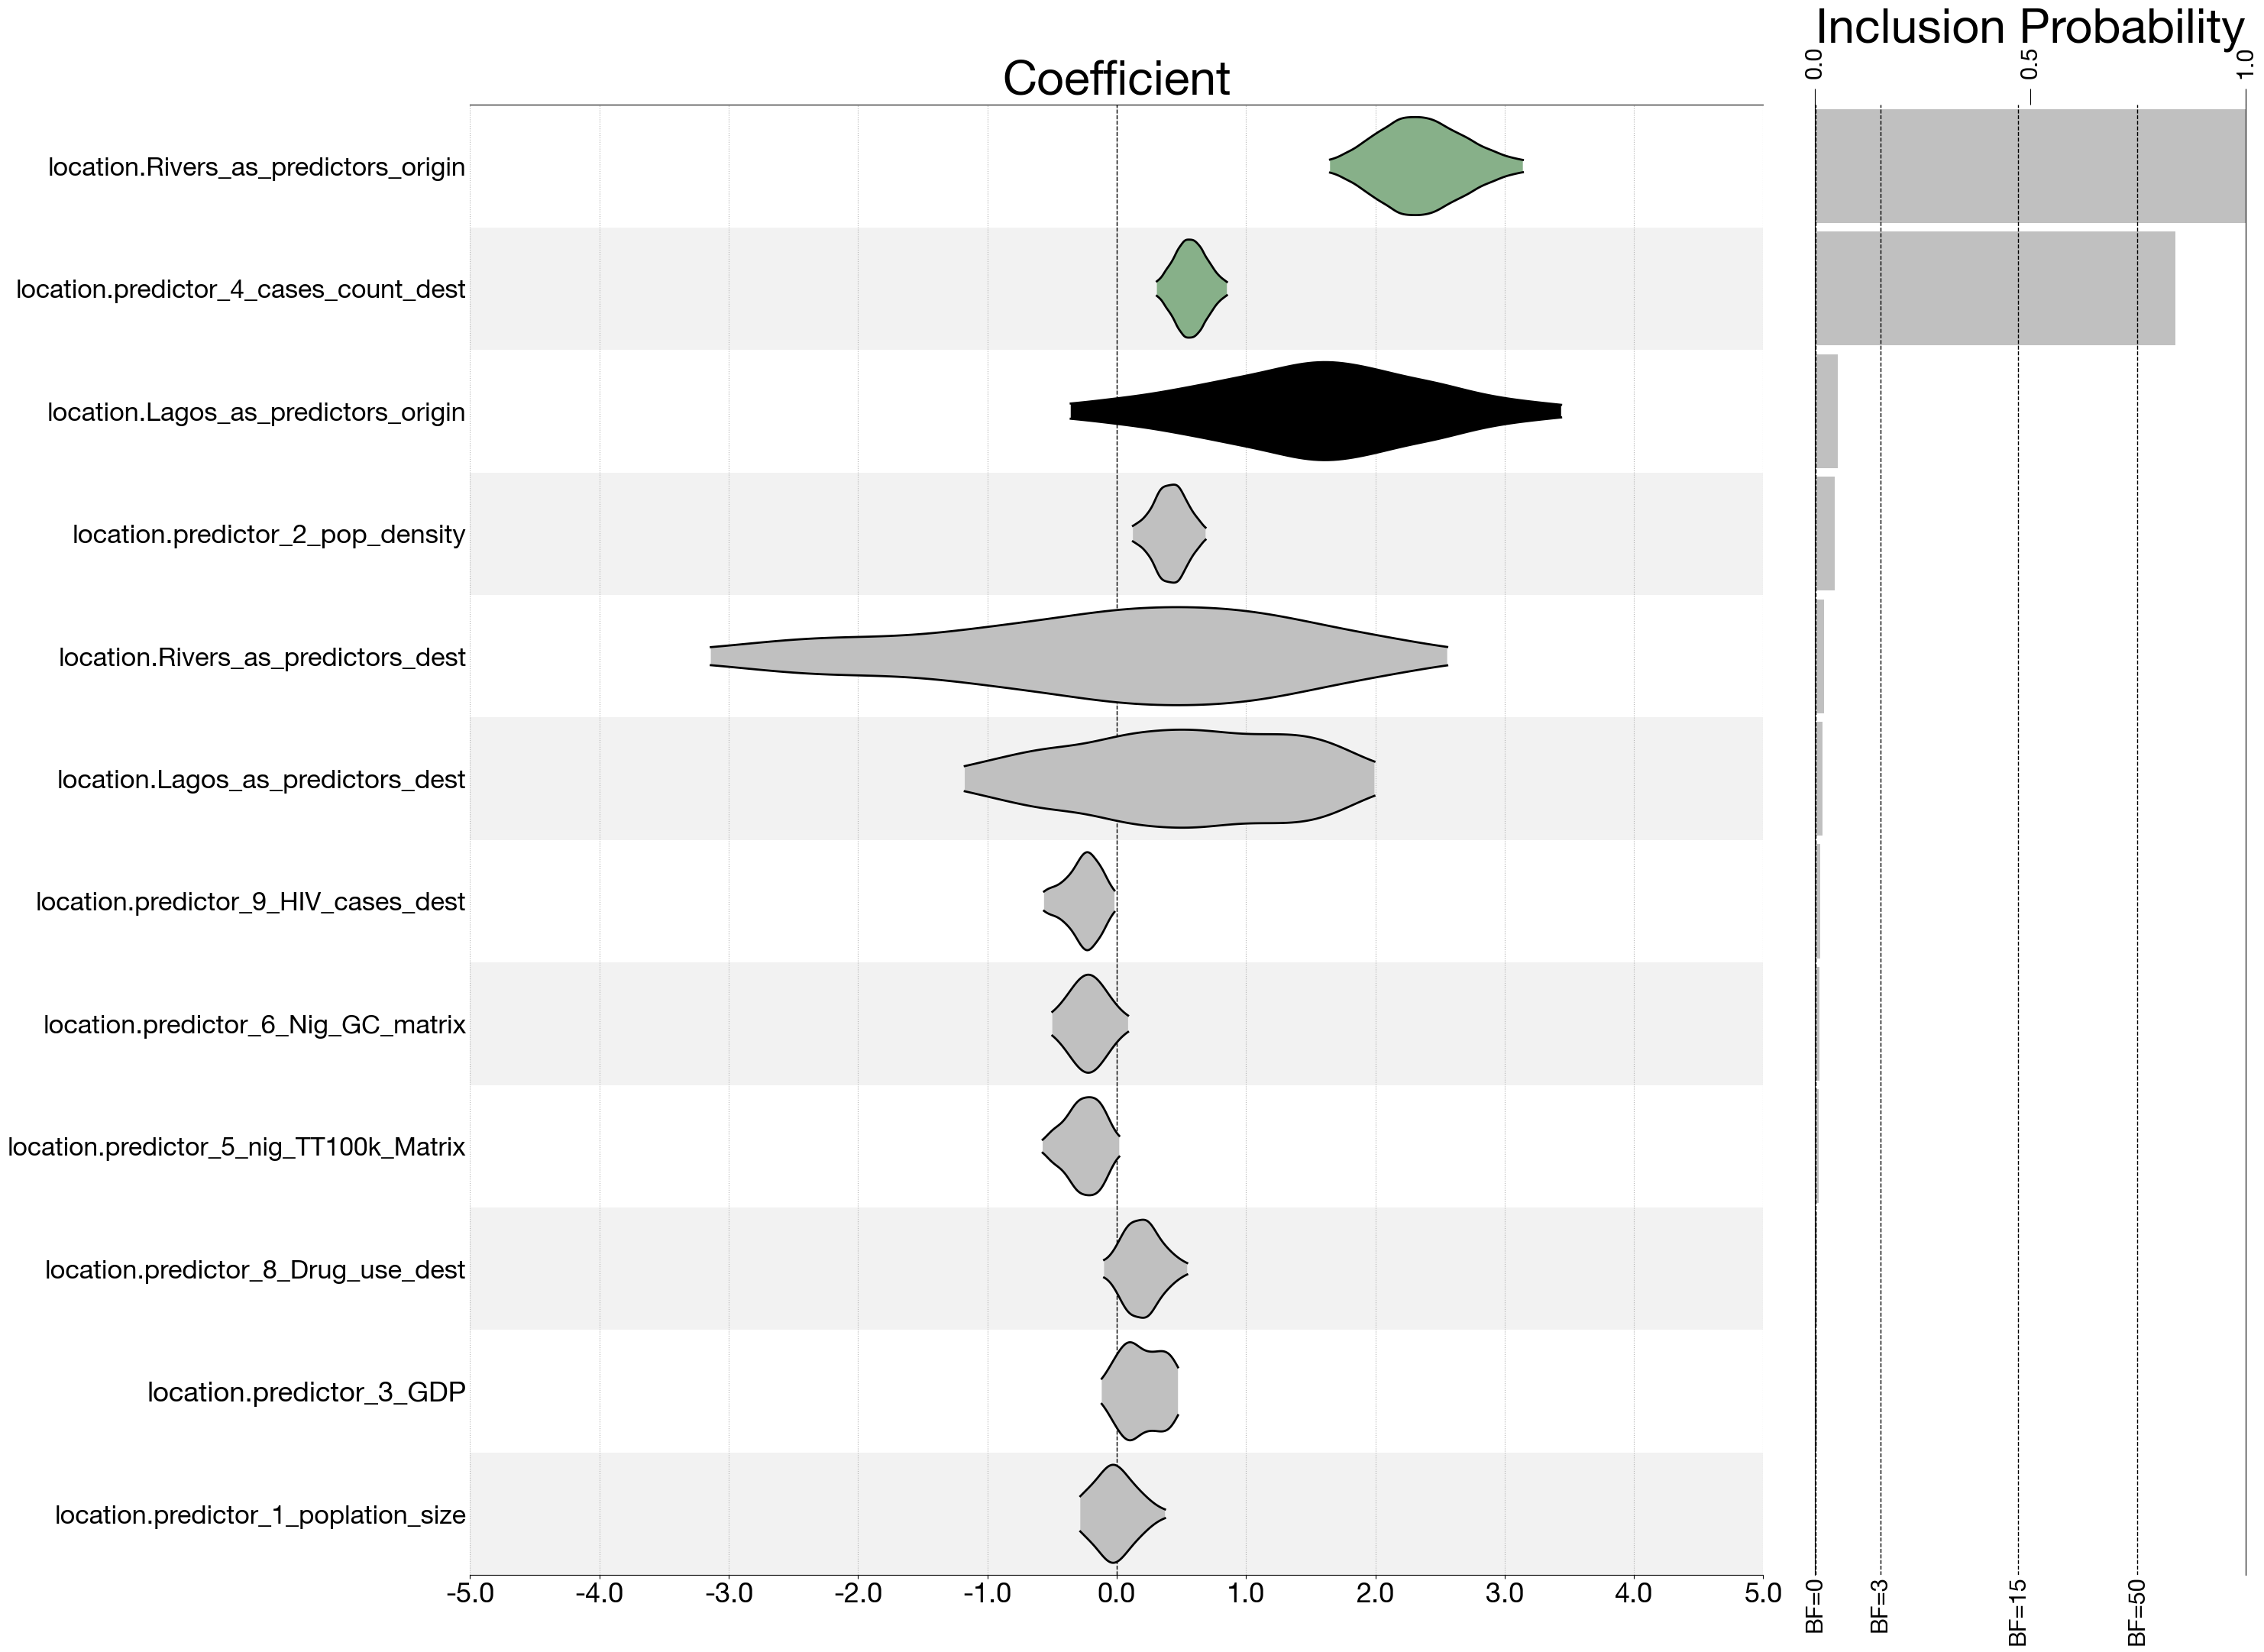

In [43]:
fig = plt.figure(figsize=(30, 25)) 
gs = gridspec.GridSpec(1, 2, width_ratios=[6, 2],wspace=0.06) ## setup figure with two columns

ax = plt.subplot(gs[0]) ## violins go into this subplot
ax2 = plt.subplot(gs[1]) ## horizontal inclusion probability bars go into this subplot

leftedge=0 ## these will provide x axis limits later on
rightedge=0

ax2.set_xlabel('Inclusion Probability',size=45) ## set x labels for both figures
ax.set_xlabel('Coefficient',size=45)

ax2.xaxis.set_label_position('top')
ax.xaxis.set_label_position('top')
ax.xaxis.labelpad=10

plotBFs=[0.01, 3, 15, 50] ## plot inclusion probabilities for BF=3, 15 and 50
cutoffs={}
for bf in plotBFs:
    posteriorOdds=priorOdds*bf
    cutoffs[bf]=posteriorOdds/(1+posteriorOdds)
    print ('%d Bayes factor cut-off = %.4f'%(bf,cutoffs[bf]))
    ax2.axvline(cutoffs[bf],color='k',lw=1,ls='--')
    ax2.text(cutoffs[bf],-0.5,'BF=%d'%(bf),size=22,ha='center',va='top',rotation=90)

predictors=sorted(GLM_coeffs.keys(),key=lambda x:(np.mean(GLM_indicators[x]),np.mean(GLM_conditional_coeffs[x]))) ## sort predictor names by support, then by coefficient

significant=[x for x in GLM_conditional_coeffs.keys() if np.mean(GLM_indicators[x])>=priorOdds*min(plotBFs)]
significant=sorted(significant,key=lambda x:(np.mean(GLM_indicators[x]),np.mean(GLM_coeffs[x])))
print (significant)

for i,x in enumerate(significant): ## for each predictor plot violins     
    support=np.mean(GLM_indicators[x])
    
    if support>=min(cutoffs.values()): ## if BF >minimum then plot coefficients conditional on it being turned on
        posterior_samples=[val for val,ind in zip(GLM_coeffs[x],GLM_indicators[x]) if ind==1.0] ## conditioned
        #posterior_samples=[val*ind for val,ind in zip(GLM_coeffs[x],GLM_indicators[x])] ## product of coefficient and indicator ("actual rate")
    else:
        posterior_samples=GLM_coeffs[x] ## otherwise plot all samples
        
    w=0.4 ## width of violins
    
    k1 = gaussian_kde(posterior_samples) #calculates the kernel density
    
    mu=np.mean(posterior_samples)
    m1,M1=hpd(posterior_samples,0.95) ## get HPDs
    
    if x in significant:
        print (predictor_description[x])
        posteriorOdds=(((support-(1/float(MCMClen)))/float((1-(support-(1/float(MCMClen)))))))
        BF=posteriorOdds/float(priorOdds)
        if BF>50.0:
            BF='%15s'%('>50')
        else:
            BF='%15.2f'%(BF)
        print ('%s\n%40s\t%.2f [%.2f, %.2f]\t%s\t%.4f'%(predictor_description[x],x,mu,m1,M1,BF,support))
    
    if m1<=leftedge: ## define new x axis minimum if new HPD is lower than current one
        leftedge=m1
    if M1>=rightedge:
        rightedge=M1

    x1 = np.linspace(m1,M1,100)  ## create a range of 100 values between lower and upper HPDs
    v1 = k1.evaluate(x1)  ## evaluate KDEs at each of the 100 values
    v1 = v1/v1.max()*w ## rescale to fit inside defined violin width

    supportFrac=min([1.0,support/float(min(cutoffs.values()))]) ## ratio of inclusion probability and smallest BF required, limited to 1.0
    
    if M1<0.0 and m1<0.0: ## define fill colours for violins depending on whether they're inside or outside HPDs
        fcolour='#16166F'
    elif M1>0.0 and m1>0.0:
        fcolour=desaturate(mpl.cm.Greens(0.5),0.5)
    if support> 1.0:
        fcolour='grey'
    if support<0.05:
        fcolour='#C0C0C0'
    
     
    ax.fill_between(x1,[i+q for q in v1],[i-q for q in v1],facecolor=desaturate(fcolour,supportFrac),edgecolor='none',alpha=supportFrac,zorder=100) ## plot violin, colour is desaturated depending on inclusion probability
    
    fcolour='k'
    ax.plot(x1,[i+w for w in v1],color=desaturate(fcolour,supportFrac),lw=2,alpha=1,zorder=100) ## plot nice edges for each violin (upper and lower)
    ax.plot(x1,[i-w for w in v1],color=desaturate(fcolour,supportFrac),lw=2,alpha=1,zorder=100)
    
    if i%2==0: ## even numbered predictor - add a grey shaded area in the background
        ax.axhspan(i-0.5,i+0.5,facecolor='k',edgecolor='none',alpha=0.05,zorder=0)
    
    ax2.barh(i,support,height=0.93,lw=2,align='center',edgecolor='none',
             facecolor=desaturate('#C0C0C0',supportFrac)) ## plot inclusion probability

ylabels=[]
for pred in significant: ## define descriptions for each predictor to be used as y axis labels
    break_at=3
    desc=predictor_description[pred]
    
    if len(desc.split(', +1'))>1: ## rectify description of predictor matrices
        description=''.join(desc.split(', +1')[:-1])
    elif len(desc.split('pseudo'))>1:
        description=''.join(desc.split(', pseudo')[:-1])
    elif len(desc.split('ln-'))>1:
        description=''.join(desc.split(', ln')[:-1])
    elif len(desc.split(',  0'))>1:
        description=''.join(desc.split(',  0')[:-1])
    else:
        description=desc
    
    break_description='\n'.join([' '.join([y for y in description.split(' ')[x:x+break_at]]) for x in range(0,len(description.split(' ')),break_at)]) ## breaks up the description into new lines to fit nicely
    
    ylabels.append(r'%s'%(break_description))
    
ax.axvline(0,ls='--',lw=1,color='k') ## add a horizontal line to main plot at coeff=0
ax.grid(axis='x',ls=':')

ax.spines['right'].set_color('none') ## make plot pretty
ax.spines['left'].set_color('none')

ax.yaxis.tick_left()

ax.set_yticks(np.arange(0,len(predictors)))
ax.set_yticklabels(predictors,size=20)
 
for tick in ax.get_yticklabels():
    tick.set_size(40-np.log10(len(list(tick.get_text())))*10)

ax2.xaxis.tick_top()
ax2.set_xticks(np.linspace(0,1,3))
ax2.set_xticklabels(np.linspace(0,1,3),rotation=90)
ax2.tick_params(axis='y',size=0)
ax2.set_yticklabels([])
ax2.tick_params(axis='x',size=15,labelsize=22,direction='out',pad=10)

ax2.spines['top'].set_color('none')
ax2.spines['bottom'].set_color('none')

ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(1))
ax.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

ax.tick_params(axis='x',labelsize=26,direction='out')
ax.tick_params(axis='y',size=0)

ax.set_ylim(-0.5,len(significant)-0.5)
ax2.set_ylim(-0.5,len(significant)-0.5)
ax.set_xlim(-5,+5)
ax2.set_xlim(0,1)
plt.savefig('../../../../Downloads/complete_datset_MPOX/MPOX_GLMlocal_output_coeff.svg', dpi=100, bbox_inches='tight')
plt.savefig('../../../../Downloads/complete_datset_MPOX/MPOX_GLMlocal_output_coeff.pdf', dpi=100, bbox_inches='tight')
plt.savefig('../../../../Downloads/complete_datset_MPOX/MPOX_GLMlocal_output_coeff.png', dpi=100, bbox_inches='tight')
plt.show()